This notebook demonstrates how a DAG can be used in combination with the assignment of a distribution to each node and a weight to each edge to create a linear SCM.

In [1]:
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from y0.graph import NxMixedGraph
from y0.dsl import V1, V2, V3, V4, V5, V6
from y0.simulation import simulate, example_graph, example_generators

In [2]:
print(sys.version)

3.10.9 (main, Jan 17 2023, 18:41:58) [Clang 12.0.0 (clang-1200.0.32.29)]


In [4]:
print(time.asctime())

Fri Feb  9 18:04:56 2024


In [3]:
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

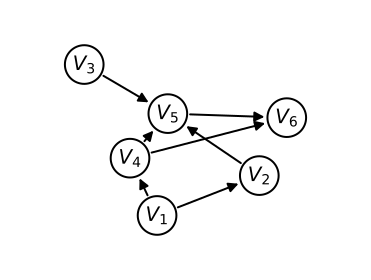

In [4]:
example_graph.draw(prog="neato")

In [15]:
example_graph.to_linear_scm_latex()

'\\begin{align*}V_1 &= \\epsilon_{V_1} \\\\\n V_3 &= \\epsilon_{V_3} \\\\\n V_2 &= V_{1} \\beta_{V_1,V_2} + \\epsilon_{V_2} \\\\\n V_4 &= V_{1} \\beta_{V_1,V_4} + \\epsilon_{V_4} \\\\\n V_5 &= V_{2} \\beta_{V_2,V_5} + V_{3} \\beta_{V_3,V_5} + V_{4} \\beta_{V_4,V_5} + \\epsilon_{V_5} \\\\\n V_6 &= V_{4} \\beta_{V_4,V_6} + V_{5} \\beta_{V_5,V_6} + \\epsilon_{V_6} \\\\\\end{align*}'

## Simulating Data

It's possible to simulate data using a linear structural causal model (SCM) given the following:

1. A directed acyclic graph (DAG) structure
2. A scalar weight for each edge in the DAG
3. A probability distribution for each node

In [16]:
df, fits = simulate(example_graph, generators=example_generators, trials=5000)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

Ultimately the simulation provides _trials_ number of data points:

In [17]:
df

,V1,V3,V2,V4,V5,V6
0,-0.041907,0.494140,0.711086,-0.137665,-1.827036,0.827917
1,-0.444821,-0.352799,-2.124326,5.881120,1.716460,5.246484
2,-0.804148,0.678696,-0.810159,1.653811,3.625481,3.311725
3,-0.594836,-2.761692,-0.788562,-1.995583,-0.232998,-4.429994
4,0.888329,-0.723931,1.473618,-3.407856,-3.875090,-3.851652
...,...,...,...,...,...,...
4995,0.286719,-0.994497,-1.101947,-0.320507,1.773488,0.314396
4996,-0.078215,-0.179728,1.513396,1.737812,0.188503,0.689088
4997,0.948277,-0.261376,2.190946,-0.586975,-2.765702,5.805594
4998,-0.127879,0.979232,-2.029011,0.606562,1.511204,0.558101


The simulation also performs several calculations over each pair of variables:

1. What's the correlation coefficient ($r^2$) between the variables?
2. Are the variables d-separated (i.e., conditionally independent)?

In [18]:
def fits_to_frame(fits):
    param_df = pd.DataFrame(
        [
            (
                a.name,
                b.name,
                t.slope,
                t.intercept,
                t.r2,
                # t.edge,
                False if t.d_separation is None else t.d_separation.separated,
                None if t.d_separation is None else t.d_separation.conditions,
            )
            for (a, b), t in fits.items()
        ],
        columns=[
            "parent",
            "child",
            "slope",
            "intercept",
            "r2",
            "d_separated",
            "d_sep_cond",
        ],
    )
    return param_df

In [19]:
param_df = fits_to_frame(fits)
param_df

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,V2,V1,0.843129,0.013662,1.529711e-01,False,None
1,V4,V1,0.192449,0.009977,3.105148e-03,False,None
2,V2,V5,0.072703,-0.027519,1.800900e-03,False,None
3,V4,V5,0.613855,-0.032134,3.295279e-01,False,None
4,V4,V6,0.462189,-0.023892,8.836058e-02,False,None
5,V6,V5,0.340635,-0.010863,5.488311e-02,False,None
6,V3,V5,0.341011,-0.031786,2.431778e-02,False,None
7,V1,V3,0.003473,0.013829,4.229685e-06,True,()
8,V1,V5,0.171049,-0.025530,2.145122e-03,True,"(V2, V4)"
9,V6,V1,0.001339,-0.020075,6.218762e-08,True,"(V2, V4)"


The following plot demonstrates that variables that are d-separated (i.e., conditionally independent) have effectively no correlation.

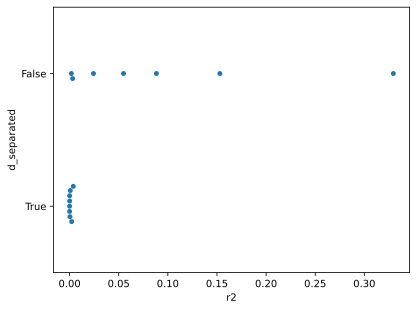

In [20]:
sns.swarmplot(data=param_df, y="d_separated", x="r2", orient="h")
plt.show()

In [21]:
from y0.algorithm.estimation.linear_scm import get_single_door

In [22]:
edge_parameters = get_single_door(example_graph, df)
edge_parameters

{(V1, V2): 0.8431285922936778,
 (V1, V4): 0.1924493079264421,
 (V2, V5): 0.0478991330585531,
 (V4, V5): 0.6130407710384929,
 (V4, V6): 0.4631491699448953,
 (V5, V6): 0.13799909377503283,
 (V3, V5): 0.3410106247797567}

## Backdoor example

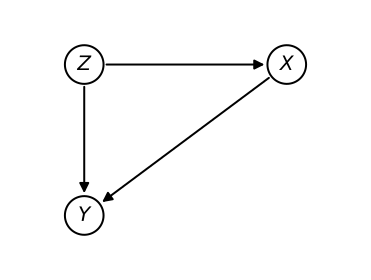

In [7]:
from y0.examples import backdoor_example

backdoor_example.graph.draw()

In [8]:
backdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}Z &= \\epsilon_{Z} \\\\\n X &= Z \\beta_{Z,X} + \\epsilon_{X} \\\\\n Y &= X \\beta_{X,Y} + Z \\beta_{Z,Y} + \\epsilon_{Y} \\\\\\end{align*}'

In [9]:
backdoor_example.graph.nodes()

NodeView((Z, X, Y))

In [10]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z

backdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [11]:
backdoor_df, backdoor_fits = simulate(
    backdoor_example.graph, generators=backdoor_generators, trials=5000
)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [12]:
backdoor_df.to_csv("../tests/test_algorithm/backdoor_example.csv")
backdoor_df

,Z,X,Y
0,-1.889530,-1.194797,-3.115274
1,-0.429591,-0.706275,-0.425465
2,-0.562891,-1.254323,0.051312
3,0.359565,0.142941,-0.354302
4,-0.630592,-0.270725,1.459253
...,...,...,...
4995,0.599100,0.828576,0.765133
4996,-0.063819,0.489791,0.090626
4997,-0.542523,0.130971,0.958924
4998,0.031279,-0.525635,-1.898522


In [13]:
fits_to_frame(backdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,X,Z,0.465981,-0.005612,0.406981,False,None
1,Z,Y,0.533183,0.003300,0.150178,False,None
2,X,Y,1.034034,0.008862,0.301362,False,None


In [14]:
backdoor_parameters = get_single_door(backdoor_example.graph, backdoor_df)
backdoor_parameters

{(Z, X): 0.4659813040231536,
 (Z, Y): 0.5331826121659358,
 (X, Y): 0.9584191797996301}

## Frontdoor example

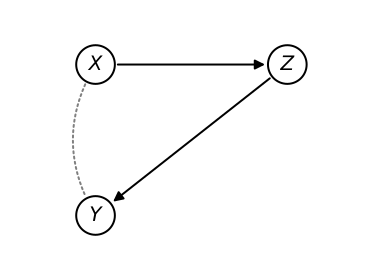

In [23]:
from y0.examples import frontdoor_example

frontdoor_example.graph.draw()

In [25]:
frontdoor_example.graph.to_linear_scm_latex()

'\\begin{align*}X &= \\epsilon_{X} + \\gamma_{X,Y} \\\\\n Z &= X \\beta_{X,Z} + \\epsilon_{Z} \\\\\n Y &= Z \\beta_{Z,Y} + \\epsilon_{Y} + \\gamma_{X,Y} \\\\\\end{align*}'

In [26]:
frontdoor_example.graph.nodes()

NodeView((X, Z, Y))

In [36]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z

frontdoor_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z: partial(normal, loc=0.0, scale=1.0),
}

In [37]:
frontdoor_df, frontdoor_fits = simulate(
    frontdoor_example.graph, generators=frontdoor_generators, trials=5000
)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [38]:
frontdoor_df.to_csv("../tests/test_algorithm/frontdoor_example.csv")
frontdoor_df

,X,Z,Y
0,-0.988446,-1.494039,0.563666
1,-0.528649,-0.999550,-1.958438
2,0.019490,1.404524,1.214141
3,0.173315,-1.313811,0.022629
4,0.619048,0.760675,0.187106
...,...,...,...
4995,0.489596,-0.730065,0.486102
4996,0.878628,0.925602,-0.048705
4997,-0.885112,0.813114,0.843479
4998,0.236213,1.363802,-1.172831


In [39]:
fits_to_frame(frontdoor_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,X,Z,0.807448,-0.029941,0.178874,False,None
1,Z,Y,0.303361,-0.010718,0.076008,False,None
2,X,Y,0.254536,-0.019866,0.014681,False,None


In [40]:
frontdoor_parameters = get_single_door(frontdoor_example.graph, frontdoor_df)
frontdoor_parameters

{(X, Z): 0.8074475606195012, (Z, Y): 0.30077413265953384}

## Napkin example

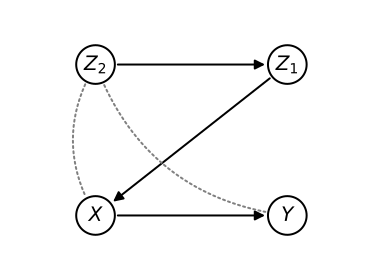

In [41]:
from y0.examples import napkin_example

napkin_example.graph.draw()

In [42]:
napkin_example.graph.to_linear_scm_latex()

'\\begin{align*}Z_2 &= \\epsilon_{Z_2} + \\gamma_{X,Z_2} + \\gamma_{Y,Z_2} \\\\\n Z_1 &= Z_{2} \\beta_{Z_2,Z_1} + \\epsilon_{Z_1} \\\\\n X &= Z_{1} \\beta_{Z_1,X} + \\epsilon_{X} + \\gamma_{X,Z_2} \\\\\n Y &= X \\beta_{X,Y} + \\epsilon_{Y} + \\gamma_{Y,Z_2} \\\\\\end{align*}'

In [43]:
napkin_example.graph.nodes()

NodeView((Z2, Z1, X, Y))

In [46]:
from functools import partial
from numpy.random import normal, uniform
from y0.dsl import X, Y, Z1, Z2

napkin_generators = {
    X: partial(uniform, low=-1.0, high=1.0),
    Y: partial(uniform, low=-2.0, high=2.0),
    Z1: partial(normal, loc=0.0, scale=1.0),
    Z2: partial(normal, loc=0.0, scale=1.0),
}

In [47]:
napkin_df, napkin_fits = simulate(napkin_example.graph, generators=napkin_generators, trials=5000)

Simulation:   0%|          | 0.00/5.00k [00:00<?, ?trial/s]

In [48]:
napkin_df.to_csv("../tests/test_algorithm/napkin_example.csv")
napkin_df

,Z2,Z1,X,Y
0,1.303360,1.264519,1.234861,1.951706
1,1.618913,2.012166,0.845813,1.491300
2,-1.149435,-0.330008,-0.911391,-1.904454
3,-0.698384,-0.817391,0.620535,-0.385763
4,1.679043,0.633866,0.374795,0.996415
...,...,...,...,...
4995,-0.198123,1.541368,0.957377,-0.631603
4996,-0.931545,0.426000,-0.108059,-1.778931
4997,-0.086115,-0.104553,-0.864597,0.168266
4998,0.847119,-0.557250,0.767514,0.416362


In [49]:
fits_to_frame(napkin_fits)

,parent,child,slope,intercept,r2,d_separated,d_sep_cond
0,Z1,Z2,0.446588,0.006635,0.162934,False,None
1,X,Z1,0.385608,0.021769,0.346475,False,None
2,X,Y,0.697430,0.036177,0.154703,False,None
3,X,Z2,0.338194,-0.027049,0.060084,False,None
4,Z1,Y,0.185204,-0.011688,0.046283,True,"(X, Z2)"
5,Z2,Y,0.067996,-0.023435,0.007637,False,None


In [50]:
napkin_parameters = get_single_door(napkin_example.graph, napkin_df)
napkin_parameters

{(Z2, Z1): 0.44658822516963126, (Z1, X): 0.3832318708801637}